This is my very first Kaggle competition! I'm excited and I picked a pretty basic one - **categorize forest cover type** based on ~50 features. Looks like a job for a decision tree. I've never used one before, so I'll be learning here!

In [144]:
import pandas as pd
from sklearn import tree
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

The training data is ~5MB so I can easily load it into memory. Yay!

In [145]:
df = pd.read_csv("../data/train.csv").drop('Id', axis=1)

In [146]:
print df.shape

(15120, 55)


In [147]:
print df.dropna().shape

(15120, 55)


No NaNs at all!? Thanks forest service!

I'm going to run this right out of the box, per SKLearn's excellent documentation.

In [148]:
clf = tree.DecisionTreeClassifier()
Y = df['Cover_Type']
X = df.drop('Cover_Type', axis=1)
clf.fit(X,Y)

DecisionTreeClassifier(compute_importances=None, criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_density=None, min_samples_leaf=1, min_samples_split=2,
            random_state=None, splitter='best')

In [149]:
print df[df['Cover_Type'] == 1].shape

(2160, 55)


Cool, it ran the decision tree. But I have no idea what the decision surface looks like. I don't even know what the important features are. Let's take a look at a Principal Component Analysis on the data:

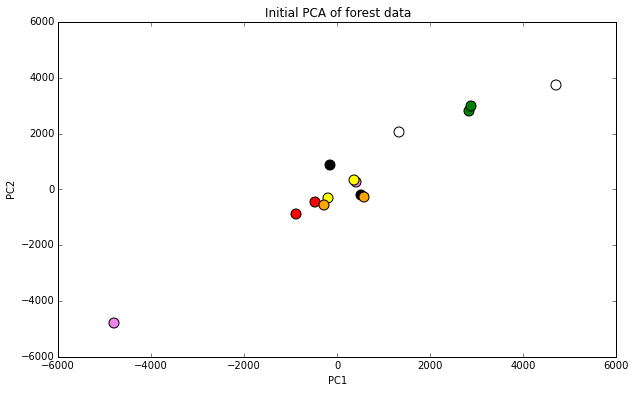

In [150]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
xy = dict()
for i in range(1,8):
    temp = df[df['Cover_Type'] == i].drop('Cover_Type', axis=1)
    xy[str(i)] = pca.fit(temp).transform(temp)


l = {'1':'white', '2':'green', '3':'black', '4':'red', '5':'violet', '6':'orange', '7':'yellow'}

fig = plt.figure(figsize=(10,6))
for i in xy:
    plt.scatter(xy[i][0], xy[i][1], label='test', c=l[i], s=100)

plt.title('Initial PCA of forest data')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

This looks very clustered and, if we were drawing a decision boundary in the PC space, it would be very difficult to get decent separation between some of the categories. But of course I haven't done any cross-validation, so I'm going to do that now.

I will iterate through a range of k-fold cross validations and see which one allows my current decision tree to best fit the cross-validation data. This will take a while to run.

In [151]:
from sklearn.cross_validation import KFold
from sklearn.metrics import accuracy_score
import time
kx = np.array(X)
ky = np.array(Y)

Executed in 153.8127s


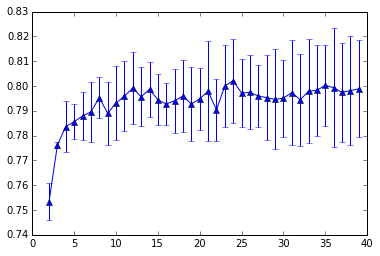

In [132]:
scores = []
std = []
index = []
start = time.clock()
for i in range(2,40):
    kf = KFold(len(df), n_folds = i, shuffle=True)
    _scores = []
    for train_index, test_index in kf:
        x_train, x_test = kx[train_index], kx[test_index]
        y_train, y_test = ky[train_index], ky[test_index]
        clf = tree.DecisionTreeClassifier()
        clf.fit(x_train, y_train)
        ypred = clf.predict(x_test)
        _scores.append(accuracy_score(y_test, ypred))
    scores.append(np.mean(np.array(_scores)))
    std.append(np.std(np.array(_scores)))
    index.append(i)
plt.errorbar(index, scores, std, marker='^')
print 'Executed in ' + str(time.clock()-start) + 's'
plt.show()

It looks like after about 12 folds in the training data, cross-validation performance starts to level off. That's good because more folds means more computing time. Unfortunately, this is only at about 80% description of the variance, which is not good enough, since the current leader has a 100% fit.

Since this is my first competition, I will take this model and submit it to see what happens. I don't expect to get very far on the leader board, but it would be personal validation to not be the worst submission.

The test data is much larger (~76MB) than the training data, but still small enough to fit into memory. I expect this will take a while, but I'll give it a shot anyway.

In [152]:
df_test = pd.read_csv("../../../../../WorkLocal/Kaggle/forest_2015/test.csv")

In [216]:
test_X = df_test.drop('Id', axis=1)
indices = df_test['Id']

In [217]:
ypred = []
start = time.clock()

kf = KFold(len(df), n_folds = 12, shuffle=True)
_scores = []
for train_index, test_index in kf:
    x_train, x_test = kx[train_index], kx[test_index]
    y_train, y_test = ky[train_index], ky[test_index]
    clf = tree.DecisionTreeClassifier()
    clf.fit(x_train, y_train)
    ypred.append(clf.predict(test_X))
    

print 'Executed in ' + str(time.clock()-start) + 's'

Executed in 4.110639s


In [219]:
Ypred = np.array(ypred).mean(0)
Ypred = np.around(Ypred)
Ypred = Ypred.astype(int)
export = pd.Series(Ypred, name='Cover_Type', index=indices)
export.index.name = 'Id'
export.to_csv('../../../../../WorkLocal/Kaggle/forest_2015/submission_1.csv', header=True, index=True)

Sweet! I am currently the **1106th best entry** (out of 1341). That's not so great, but hey it's my first one. My model only explained **60%** of the variation, so let's see what more I can do beyond using a default decision tree/k-fold CV methodology. 